In [6]:
import itertools
import argparse
import numpy as np
import pandas as pd
import sklearn
import random
import sklearn.metrics
import time
import os
import sys
import json
import gc
import json
import hashlib
import tempfile
from collections import Counter
import keras.optimizers
import cv2
from math import ceil
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Reshape
import ast
import h5py
from keras.utils import np_utils
from itertools import tee
import keras.backend as K
import tensorflow as tf
from tensorflow.python.framework.graph_util import convert_variables_to_constants
from IPython.display import display, clear_output
import PIL.Image
from cStringIO import StringIO
import IPython.display
import matplotlib.pyplot as plt

In [7]:
computed_metrics = ['accuracy', 'mean_squared_error']

# In case we want more callbacks
def get_callbacks(model_fname, patience=2):
    return [ModelCheckpoint(model_fname)]
    return [EarlyStopping(monitor='loss',     patience=patience, min_delta=0.00001),
            EarlyStopping(monitor='val_loss', patience=patience + 2, min_delta=0.0001),
            ModelCheckpoint(model_fname, save_best_only=True)]

def get_loss():
    return 'categorical_crossentropy'

def get_optimizer(lr_mult):
#     return keras.optimizers.RMSprop(lr=lr_mult)# / (5 * nb_layers))
    return keras.optimizers.Adam(lr=lr_mult)# / (5 * nb_layers))


def generate_conv_net_base(
        input_shape, nb_classes,
        nb_dense=128, nb_filters=32, nb_layers=1, lr_mult=0.001,
        kernel_size=(3, 3), stride=(1, 1)):
    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                            border_mode='same',
                            input_shape=input_shape,
                            subsample=stride,
                            activation='relu'))
    model.add(Convolution2D(nb_filters, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    nb_filter_multiplier = 2
    
    for i in range(nb_layers - 1):
        model.add(Convolution2D(nb_filters * nb_filter_multiplier,
                                3, 3, border_mode='same', activation='relu'))
        model.add(Convolution2D(nb_filters * nb_filter_multiplier,
                                3, 3, border_mode='same', activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        nb_filter_multiplier += 1

    model.add(Flatten())
    model.add(Dense(nb_dense, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    loss = get_loss()
    model.compile(loss=loss,
                  optimizer=get_optimizer(lr_mult),
                  metrics=computed_metrics)
    return model

# def evaluate_model(model, X_test, Y_test, batch_size=256):
#     predicted_labels, test_time = get_labels(model, X_test, batch_size, True)
#     true_labels = Y_test.argmax(axis=-1)

#     confusion = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

#     # Minor smoothing to prevent division by 0 errors
#     TN = float(confusion[0][0]) + 1
#     FN = float(confusion[1][0]) + 1
#     TP = float(confusion[1][1]) + 1
#     FP = float(confusion[0][1]) + 1
#     metrics = {'recall': TP / (TP + FN),
#                'specificity': TN / (FP + TN),
#                'precision': TP / (TP + FP),
#                'npv':  TN / (TN + FN),
#                'fpr': FP / (FP + TN),
#                'fdr': FP / (FP + TP),
#                'fnr': FN / (FN + TP),
#                'accuracy': (TP + TN) / (TP + FP + TN + FN),
#                'f1': (2 * TP) / (2 * TP + FP + FN),
#                'test_time': test_time}
#     return metrics

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [8]:
# def get_csv_samples(csv_fname, OBJ):
#     df = pd.read_csv(csv_fname)
#     df = df[df['object_name'].isin([OBJ])]
#     groups = df.set_index('frame')
#     return groups.index

def contain_rect(br, sr):
    return br[0] <= sr[0] and br[1] <= sr[1] and br[2] >= sr[2] and br[3] >= sr[3]

def check_location(obj_ids, df, crop, full_resol=(720, 1280), remove=False):
    new_obj_ids = []
    lines = df.values.tolist()
    for line in lines:
        xmin = max(0, line[3])
        ymin = max(0, line[4])
        xmax = min(full_resol[1], line[5])
        ymax = min(full_resol[0], line[6])
        if contain_rect(crop, [ymin, xmin, ymax, xmax]):
            new_obj_ids.append(line[0])
#             print [ymin, xmin, ymax, xmax], crop
    new_obj_ids = list(set(new_obj_ids))
    print ('Number of pos objects not in crop: %d/%d, remove: ' %
           (len(obj_ids) - len(new_obj_ids), len(obj_ids)), remove)
    if remove:
        return new_obj_ids
    else:
        return obj_ids
        

def get_csv_samples(csv_fname, OBJ, limit, begin=0, WINDOW=10):
    df = pd.read_csv(csv_fname)
    df = df[df['object_name'].isin([OBJ])]
    groups = df.set_index('frame')
    counts = map(lambda i: i in groups.index, range(begin, limit))
    counts = np.array(counts)
    idx = np.argwhere(counts > 0)[:,0]
    
    smoothed_counts = np.convolve(np.ones(WINDOW), np.ravel(counts), mode='same') > WINDOW * 0.6
    print ("pos samples before/after smooth: %d/%d" % (np.sum(counts), np.sum(smoothed_counts)))
    smoothed_counts = smoothed_counts.reshape(len(counts), 1)
    counts = smoothed_counts
    idx = np.argwhere(counts > 0)[:,0]
    return idx

def get_csv_samples_counting(csv_fnames, img_nums, OBJ, limit, nb_classes,
                             begin=0, crop=(-1, -1, -1, -1)):
    assert len(csv_fnames) == len(img_nums), 'csv and img sub shall be same!'
    dfs = []
    for idx, csv_fname in enumerate(csv_fnames):
        df = pd.read_csv(csv_fname)
        df = df[df['object_name'].isin([OBJ])]
        df['frame'] = df['frame'] + sum(img_nums[:idx])
        dfs.append(df)
    df = pd.concat(dfs, axis = 0, ignore_index = True)
    groups = df.set_index('frame')
    counts = map(lambda i: 0, range(begin, limit))
    for idx in list(groups.index):
        if idx < limit:
            counts[idx] += 1
    counts = [x if (x < nb_classes - 1) else nb_classes - 1 for x in counts]
    return counts

def get_labels(counts, frameset, nb_classes):
    ret = [counts[t] for t in frameset]
    print ('reading label sum: %d, distribution: %s' % (len(ret), str(Counter(ret))))
    return np_utils.to_categorical(ret, nb_classes)

def get_frames_from_images(frameset, img_dirs, img_nums,
                           resol=(-1, -1), crop=(-1, -1, -1, -1), dtype='float32'):
    def get_image_path(idx):
        for i in range(len(img_dirs)):
            if sum(img_nums[:i + 1]) > idx:
                return os.path.join(img_dirs[i], str(idx - sum(img_nums[:i]) + 1).zfill(7) + '.jpg')
    assert len(img_dirs) == len(img_nums), 'image subdir numbers not consistent!'
    print ('reading images... %d') % (len(frameset))
    if resol[0] > 0:
        frames = np.zeros(tuple([len(frameset)] + list(resol) + [3]), dtype=dtype )
    else:
        test_frame = cv2.imread(os.path.join(img_dirs[0], '0000001.jpg'))
        frames = np.zeros(tuple([len(frameset)] + list(test_frame.shape)), dtype=dtype )
    for i in range(len(frameset)):
        img_path = get_image_path(frameset[i])
        frame = cv2.imread(img_path)
        if crop[0] > 0:
            frame = frame[crop[0]:crop[2],crop[1]:crop[3],:]
        if resol[0] > 0:
            frame = cv2.resize(frame, (resol[1], resol[0]), interpolation=cv2.INTER_NEAREST)
        frames[i, :] = frame

    if dtype == 'float32':
        frames /= 255.0

    return frames
def resize_images(frames, resol, dtype='float32'):
    new_frames = np.zeros(tuple([frames.shape[0]] + list(resol) + [3]), dtype=dtype)
    for i in range(frames.shape[0]):
        one_frame = cv2.resize(frames[i,:,:,:], (resol[1], resol[0]), interpolation=cv2.INTER_NEAREST)
        new_frames[i, :] = one_frame
    return new_frames

In [9]:
def train_model(model, X_train, Y_train, batch_size=32, nb_epoch=10, patience=2):
    print ('training samples: %d/%d' % (
            np.count_nonzero(Y_train.argmax(axis=-1)), X_train.shape[0]))
    temp_fname = tempfile.mkstemp(suffix='.hdf5', dir='/tmp/')[1]

    validation_split = 0.33333333
    if len(Y_train) * validation_split > 50000.0:
        validation_split = 50000.0 / float(len(Y_train))
#         print validation_split

    begin_train = time.time()
    model.fit(X_train, Y_train,
                batch_size=batch_size,
                nb_epoch=nb_epoch,
                # validation_split=validation_split,
                # validation_data=(X_test, Y_test),
                shuffle=True,
                class_weight='auto',
                callbacks=get_callbacks(temp_fname, patience=patience))
    train_time = time.time() - begin_train

    model.load_weights(temp_fname)
    os.remove(temp_fname)

    return train_time
def test_model(model, X_test, Y_test, batch_size=128, save_fname=None):
    probs = model.predict(X_test, batch_size=128, verbose=0)
    return probs, Y_test

In [10]:
JPG_ROOT_PATH = '/host/4TB_hybridvs_data/YOLO-RES/jpg'
CSV_ROOT_PATH = '/host/4TB_hybridvs_data/YOLO-RES/out'
RES_ROOT_PATH = '/host/4TB_hybridvs_data/YOLO-RES/exp/counting'
FRAMES_PER_SEC = 10 # frame rate we decode the video
FULL_RESOL = (720, 1280) # default 720p

def str2ilst(s):
    return [int(x) for x in s.split(',')]

def get_intermediate_fname(cur_cfg):
    cfg_str = json.dumps(cur_cfg)
    cfg_md5 = hashlib.md5(cfg_str).hexdigest()
    cfg_fname = os.path.join(RES_ROOT_PATH, 'intermediate', cfg_md5)
    return cfg_fname

def read_input(obj_ids, input_cfg, total_frame_num, img_sub_dirs, img_sub_nums,
               nb_classes, max_resol=(200, 200)):
    print 'reading input for config:', input_cfg
    train_num = input_cfg[0]
    test_num = input_cfg[1]
    wnd_num = input_cfg[2]
    train_pos_ratio = input_cfg[3]
    crop = str2ilst(input_cfg[4])
    train_num_wnd = train_num / wnd_num
    test_num_wnd = test_num / wnd_num
    wnd_size = total_frame_num / wnd_num
    frame_ids_wnd = []
    train_ids = []
    X_train_wnds = []
    Y_train_wnds = []
    test_ids = []
    X_test_wnds = []
    Y_test_wnds = []
    for i in range(wnd_num):
        ids_wnd = range(i * wnd_size, (i + 1) * wnd_size, 1)
        if train_pos_ratio < 0:
            train_ids_wnd = random.sample(ids_wnd, train_num_wnd)
        else:
            train_ids_pos_wnd = random.sample(
                [x for x in ids_wnd if x in obj_ids], int(train_num_wnd * train_pos_ratio))
            train_ids_neg_wnd = random.sample(
                [x for x in ids_wnd if x not in obj_ids], int(train_num_wnd * (1 - train_pos_ratio)))
            train_ids_wnd = train_ids_pos_wnd + train_ids_neg_wnd
            random.shuffle(train_ids_wnd)
        test_ids_wnd = random.sample(
            [x for x in ids_wnd if x not in train_ids_wnd], test_num_wnd)
        train_ids.append(train_ids_wnd)
        test_ids.append(test_ids_wnd)
        X_train_wnds.append(get_frames_from_images(
            train_ids_wnd, img_sub_dirs, img_sub_nums, resol=max_resol, crop=crop))
        Y_train_wnds.append(get_labels(obj_ids, train_ids_wnd, nb_classes))
        X_test_wnds.append(get_frames_from_images(
            test_ids_wnd, img_sub_dirs, img_sub_nums, resol=max_resol, crop=crop))
        Y_test_wnds.append(get_labels(obj_ids, test_ids_wnd, nb_classes))
    return X_train_wnds, Y_train_wnds, X_test_wnds, Y_test_wnds

def gen_model(resol, model_param, nb_classes, pre_model=None, model_type='AlexNet'):
    if model_type == 'AlexNet':
        param = ((resol[0], resol[1], 3), nb_classes, model_param[0], model_param[1], model_param[2])
        model = generate_conv_net_base(*param, lr_mult=0.001)
    elif model_type == 'MobileNet':
        model = keras.applications.mobilenet.MobileNet(
            input_shape=(resol[0], resol[1], 3),
            alpha=0.25, depth_multiplier=1, dropout=1e-3,
            include_top=True, weights=None, classes=2)
        model.compile(loss=get_loss(),
                  optimizer=get_optimizer(lr_mult=0.001),
                  metrics=computed_metrics)
    else:
        print ('No such model supported: ' + model_type)
    if pre_model != None:
        model.set_weights(pre_model.get_weights())
    return model

def save_res(cfg_str, probs, Y):
    prob_fname = os.path.join(RES_ROOT_PATH, cfg_str + '-probs.npy')
    Y_fname = os.path.join(RES_ROOT_PATH, cfg_str + '-Y.npy')
    with open(prob_fname, 'w+') as f:
        np.save(f, probs)
    with open(Y_fname, 'w+') as f:
        np.save(f, Y)

def already_saved(cfg_str):
    prob_fname = os.path.join(RES_ROOT_PATH, cfg_str + '-probs.npy')
    return os.path.exists(prob_fname)
        
def run_models(X_train_wnds, Y_train_wnds, X_test_wnds, Y_test_wnds, video_cfg, cur_cfg):
    nb_epoch=20
    out_file = os.path.join(RES_ROOT_PATH, cur_cfg['video'] + '.json')
    resol = cur_cfg['resol']
    X_train_total = np.concatenate(X_train_wnds, axis=0)
    Y_train_total = np.concatenate(Y_train_wnds, axis=0)
    X_test_total = np.concatenate(X_test_wnds, axis=0)
    Y_test_total = np.concatenate(Y_test_wnds, axis=0)
    print cur_cfg
    for model_cfg in video_cfg['model']:
        cur_cfg['model'] = model_cfg
        param = str2ilst(model_cfg)
        cur_cfg['generic'] = True
        if already_saved(json.dumps(cur_cfg)): continue
        generic_model = gen_model(resol, param, video_cfg['nb_classes'])
        train_model(generic_model, X_train_total, Y_train_total, batch_size=64, nb_epoch=nb_epoch)
        _probs, _Y = test_model(generic_model, X_test_total, Y_test_total,
                                        save_fname=get_intermediate_fname(cur_cfg))
        save_res(json.dumps(cur_cfg), _probs, _Y)
        cur_cfg['generic'] = False
        probs_lst = []
        Y_lst = []
        for i in range(len(X_train_wnds)):
            model = gen_model(resol, param, video_cfg['nb_classes'], pre_model=generic_model)
            train_model(model, X_train_wnds[i], Y_train_wnds[i], batch_size=32, nb_epoch=10)
            _probs, _Y = test_model(model, X_test_wnds[i], Y_test_wnds[i],
                                            save_fname=get_intermediate_fname(cur_cfg))
            probs_lst.append(_probs)
            Y_lst.append(_Y)
        save_res(json.dumps(cur_cfg),
                 np.concatenate(probs_lst, axis=0),
                 np.concatenate(Y_lst, axis=0))
        del generic_model
        del model
        K.clear_session()
        
def run_once(video_name, video_cfg):
    # iterate input formats
    video_clip_num = video_cfg['VIDEO_CLIP_NUM']
    total_frame_num = 200000 * video_clip_num # ~200000 frames each video clip
    input_cfgs = list(itertools.product(
        video_cfg['train_num'],
        video_cfg['test_num'],
        video_cfg['wnd_num'],
        video_cfg['train_pos_ratio'],
        video_cfg['crop']
    ))
    sub_videos = [video_name + '-' + str(p + 1) for p in range(video_clip_num)]
    img_sub_dirs = [os.path.join(JPG_ROOT_PATH, v) for v in sub_videos]
    img_sub_nums = [len(os.listdir(d)) for d in img_sub_dirs]
    nb_classes = video_cfg['nb_classes']
    csv_sub_files = [os.path.join(CSV_ROOT_PATH, d + '.csv') for d in sub_videos]
    cur_cfg = {'video': video_name}
    for OBJECT in video_cfg['OBJECT']:
        cur_cfg['OBJECT'] = OBJECT
        obj_ids = get_csv_samples_counting(
            csv_sub_files, img_sub_nums, OBJECT, total_frame_num, nb_classes)
        for input_cfg in input_cfgs:
            cur_cfg['input_cfg'] = input_cfg
            X_train_wnds, Y_train_wnds, X_test_wnds, Y_test_wnds = read_input(
                obj_ids, input_cfg, total_frame_num, img_sub_dirs, img_sub_nums, nb_classes)
            for _resol in video_cfg['resol']:
                resol = str2ilst(_resol)
                cur_cfg['resol'] = resol
                resized_X_train_wnds = [resize_images(frames, resol, dtype='float32')
                                        for frames in X_train_wnds]
                resized_X_test_wnds = [resize_images(frames, resol, dtype='float32')
                                       for frames in X_test_wnds]
                
                run_models(resized_X_train_wnds, Y_train_wnds, resized_X_test_wnds, Y_test_wnds,
                           video_cfg, cur_cfg)
                del resized_X_train_wnds
                del resized_X_test_wnds
            del X_train_wnds
            del Y_train_wnds
            del X_test_wnds
            del Y_test_wnds

In [ ]:
# automate experiments
with open('exp_params_counting.cfg') as f:
    cfg = json.load(f)

for video in cfg.keys():
    run_once(video, cfg[video])
    gc.collect()

In [274]:
# try sampling
JPG_ROOT_PATH = '/host/4TB_hybridvs_data/YOLO-RES/jpg'
CSV_ROOT_PATH = '/host/4TB_hybridvs_data/YOLO-RES/out'
RES_ROOT_PATH = '/host/4TB_hybridvs_data/YOLO-RES/exp/counting'
FRAMES_PER_SEC = 10 # frame rate we decode the video
FULL_RESOL = (720, 1280) # default 720p
video_name = 'banff'
OBJECT = 'car'
video_clip_num = 4
nb_classes = 10
total_frame_num = 200000 * video_clip_num
sub_videos = [video_name + '-' + str(p + 1) for p in range(video_clip_num)]
img_sub_dirs = [os.path.join(JPG_ROOT_PATH, v) for v in sub_videos]
img_sub_nums = [len(os.listdir(d)) for d in img_sub_dirs]
csv_sub_files = [os.path.join(CSV_ROOT_PATH, d + '.csv') for d in sub_videos]
counts = get_csv_samples_counting(
            csv_sub_files, img_sub_nums, OBJECT, total_frame_num, nb_classes)

1.9484722222222222 36000
[0.13405641309821356, 0.17721454538048728, 0.06654073704469317, 0.02092917418314801, 0.12753452264465162, 0.05781520794346039, 0.08676564930626897, 0.06886754987118517, 0.11318707024383108, 0.01931712880461906, 0.12613447434175926, 0.05381709316415994, 0.020211380322578482, 0.03851966676621932, 0.07619930144700258, 0.03270403293526132, 0.01632333024449348, 0.0025744015303847236, 0.09019628172810865, 0.019174566968422475, 0.07059340214624545, 0.04378524184865181, 0.11495284549060907, 0.00948036210706394, 0.01839947349007287, 0.05102234320551629, 0.010880060135174523, 0.1098085697326082, 0.02180647779051089, 0.03343075058806756, 0.13778601468386914, 0.03042369046178435, 0.08845536378269742, 0.06955325325597382, 0.009195238434670995, 0.046974125026730394, 0.00951305144530003, 0.010798189812392119, 0.023461368228934444, 0.044835697483783535, 0.003267667350713319, 0.018746881459833286, 0.014709422664911083, 0.003635326823009479, 0.03343075058806756, 0.01135024293531

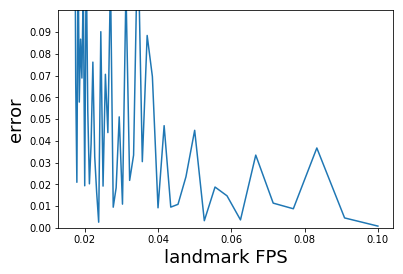

In [167]:
query_frame_num = 36000 * 1
counts_ranged = counts[:query_frame_num]
grd = np.mean(counts_ranged)
print np.mean(counts_ranged), len(counts_ranged)

# sample at interval (landmarks)
landmark_interval = [FRAMES_PER_SEC * i for i in range(10, 60, 1)]
FPS = [FRAMES_PER_SEC / float(i) for i in landmark_interval]
y = [np.mean([counts_ranged[i] for i in range(0, query_frame_num, interval)])
         for interval in landmark_interval]
y = [abs(t - grd) / grd for t in y]
print y[::-1]
plt.plot(FPS, y)
plt.xlabel('landmark FPS', fontsize=18)
plt.ylabel('error', fontsize=18)
plt.ylim(0, 0.1)
plt.yticks(np.arange(0, 0.1, 0.01))
plt.show()

1.9484722222222222 36000


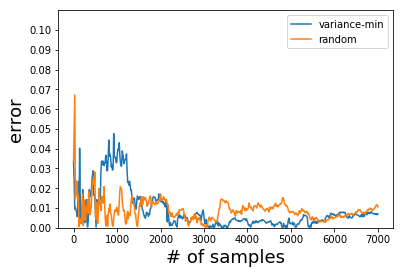

In [277]:
# variance-based sampling
with open('banff.counts') as f:
    counts = np.load(f)
query_frame_num = 36000 * 1
counts_ranged = counts[:query_frame_num]
grd = np.mean(counts_ranged)
print np.mean(counts_ranged), len(counts_ranged)

blk_num = 10
blk_sz = query_frame_num / blk_num
lmk_interval = 300
step_num = 500
step_sz = query_frame_num / step_num / 5

# variance-controlled sampling
blk_idx = [range(blk_sz * i, blk_sz * (i + 1), lmk_interval)
           for i in range(blk_num)]
blk_avg = [np.mean([counts_ranged[i] for i in blk_idx[b]])
           for b in range(blk_num)]
blk_avg_chg = [100000 for b in range(blk_num)]
x = range(0, step_sz * (step_num + 1), step_sz)
res = [abs(np.mean(blk_avg) - grd) / grd]
for i in range(step_num):
    cur_blk = np.argmax(blk_avg_chg)
#     print 'block selected: ', cur_blk
    new_idx = range(blk_sz * cur_blk, blk_sz * (cur_blk + 1), 1)
    new_idx = list(set(new_idx).difference(blk_idx[cur_blk]))
    new_idx = random.sample(new_idx, step_sz)
    blk_idx[cur_blk] += new_idx
    new_avg = np.mean([counts_ranged[i] for i in blk_idx[cur_blk]])
    blk_avg_chg[cur_blk] = abs(new_avg - blk_avg[cur_blk])
    blk_avg[cur_blk] = new_avg
    res.append(abs(np.mean(blk_avg) - grd) / grd)
plt.plot(x, res)

# random sampling
lmk_idx = range(0, query_frame_num, lmk_interval)
lmk_counts = [counts_ranged[i] for i in lmk_idx]
rmd_idx = random.sample([i for i in range(query_frame_num) if i not in lmk_idx], max(x))
rmd_counts = [counts_ranged[i] for i in rmd_idx]
res2 = []
for i in range(step_num + 1):
    cur_counts = lmk_counts + rmd_counts[:i * step_sz]
    res2.append(abs(np.mean(cur_counts) - grd) / grd)
plt.plot(x, res2)

# dev-control sampling


plt.legend(['variance-min', 'random'])
plt.xlabel('# of samples', fontsize=18)
plt.ylabel('error', fontsize=18)
plt.ylim(0, 0.11)
plt.yticks(np.arange(0, 0.11, 0.01))
plt.show()

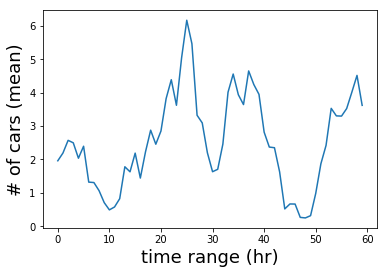

In [88]:
step = 60
step_size = total_frame_num / step
x = range(step)
y = [np.mean(counts[i * step_size:(i + 1) * step_size]) for i in x]
plt.plot(x, y)
plt.xlabel('time range (hr)', fontsize=18)
plt.ylabel('# of cars (mean)', fontsize=18)
plt.show()

In [268]:
with open('banff.counts', 'w+') as f:
    np.save(f, counts)